<a href="https://colab.research.google.com/github/dujest/yolov5-workshop/blob/main/YOLOv5_Hyperparameter_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/

In [ ]:
!mkdir ./colab

In [ ]:
%cd /content/drive/MyDrive/colab

/content/drive/MyDrive/colab


# Install Requirements

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

/content/drive/MyDrive/colab/yolov5
     |████████████████████████████████| 1.6 MB 51.5 MB/s 
     |████████████████████████████████| 145 kB 40.4 MB/s 
     |████████████████████████████████| 178 kB 54.5 MB/s 
     |████████████████████████████████| 1.1 MB 60.3 MB/s 
     |████████████████████████████████| 67 kB 2.8 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 138 kB 60.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


# Get a Dataset

In [ ]:
!mkdir ../datasets

In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/drive/MyDrive/colab/datasets"

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="hqecDDiHcpNES0AxG9i3")
project = rf.workspace("caitlin-hall").project("shipclassification")
dataset = project.version(3).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/drive/MyDrive/colab/datasets/ShipClassification-3 in yolov5pytorch:: 100%|██████████| 2714/2714 [00:20<00:00, 134.22it/s]


# Hyperparameter Evolution

Hyperparameters in ML control various aspects of training, and finding optimal values for them can be a challenge. Traditional methods like grid searches can quickly become intractable due to
<br>
1) the high dimensional search space,
<br>
2) unknown correlations among the dimensions,
<br>
3) expensive nature of evaluating the fitness at each point.
<br>
These reasons makes GA a suitable candidate for hyperparameter searches.

In [ ]:
!python train.py --epochs 10 --data '/content/drive/MyDrive/colab/datasets/ShipClassification-3/data.yaml' --weights yolov5m.pt --cache --evolve

# Train the data

In [ ]:
!python train.py --img 416 --batch 32 --epochs 150 --data '/content/drive/MyDrive/colab/datasets/ShipClassification-3/data.yaml' --weights yolov5m.pt --cache --hyp "/content/drive/MyDrive/colab/yolov5/runs/evolve/exp/hyp_evolve.yaml"

# Evaluate the model performance

In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/colab/yolov5/runs/train/

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
metrics_list = ['metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'metrics/precision', 'metrics/recall']

plt.rcParams["figure.figsize"] = (10,10)

def metrics_plotting(path_list, num):
    for n, metric in enumerate (metrics_list):
        n += 1
        plt.subplot(2, 2, n)
        for path in path_list:
            data = pd.read_csv(path_list[path], sep=',', header=0, skipinitialspace=True)
            data.rename(columns={metric : path}, inplace=True)
            spline = make_interp_spline(data['epoch'], data[path])
            epochs = np.linspace(0, len(data), num)
            spline_values = spline(epochs)
            spline_values[-1]=data[path].to_numpy()[-1]
            plt.plot('epoch', path, data=data, linestyle=':', linewidth=1, alpha=0.8)
            plt.plot(epochs, spline_values, linewidth=2, label=path)
        plt.title(metric)
        plt.xlabel('epoch')
        plt.legend()
    plt.show()

In [ ]:
def metrics_table(path_list):
    for n, path in enumerate(path_list):
        train_data = pd.read_csv(path_list[path], sep=',', header=0, skipinitialspace=True)
        train_data.rename(index={len(train_data)-1 : path}, inplace=True)
        train_metrics = train_data.iloc[:, [4, 5, 6, 7]]
        comparison_data = train_metrics.tail(1)
        if n == 0:
            comparsion_table = pd.concat([comparison_data])
        else:
            comparsion_table = pd.concat([comparsion_table, comparison_data])   

    return comparsion_table

In [ ]:
path_list = {'The best weights': '/content/drive/MyDrive/colab/yolov5/runs/train/exp/results.csv',
            }

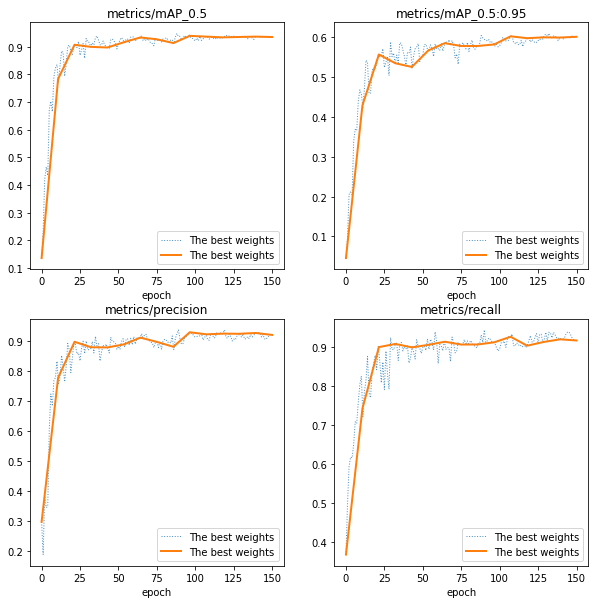

,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95
The best weights,0.9196,0.91715,0.93513,0.60132


In [ ]:
metrics_plotting(path_list=path_list, num=15)
metrics_table(path_list=path_list)